In [1]:
import random
from transformers import pipeline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
import numpy as np
from huggingface_hub import notebook_login
import wandb
import os
import time
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoModel

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina' # 主题

In [3]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
plt.rcParams['figure.figsize'] = 12, 8

In [4]:
# print(torch.__version__)
# print(torch.backends.cudnn.version())
# print(torchvision.__version__)
# print(torchtext.__version__)

In [5]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark     = False  # 启用Cudnn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [6]:
# 模型相关参数
base_model_name = 'roberta-llama3.1405B-twitter-sentiment'
TEST_DATASET_SIZE = 0.2
NUM_LABELS = 3
DATA_PATH = f'../data/citation_sentiment_corpus_new.csv'

# BASE_MODEL_PATH = f'./citation_finetuned_models/{base_model_name}'
BASE_MODEL_PATH = f'../pretrain_models/{base_model_name}'

# 训练相关参数
BATCH_SIZE = 32
loss_type='focal_loss' # 自定义参数 focal_loss dsc_loss ce_loss asymmetric_loss
weight_decay = 0.05  # 0.01
lr = 2.0e-5  # 2e-5学习率，bs设置较大 5e-6
num_epochs = 5
warmup_ratio = 0.1
warmup_steps = 100
label_smoothing_factor = 0.1

# notebook_login()
os.environ["WANDB_PROJECT"] = base_model_name
os.environ["WANDB_LOG_MODEL"] = 'true' # save your trained model checkpoint to wandb
os.environ["WANDB_WATCH"] = 'false' # turn off watch to log faster

In [7]:
df = pd.read_csv(DATA_PATH)
texts = df['Citation_Text'].tolist()
labels = df['Sentiment'].tolist()
print(df.shape)
df.head()

(8699, 5)


,Source_Paper_ID,Target_Paper_ID,Sentiment,Citation_Text,Sentence_Length
0,A00-1043,A00-2024,0,We analyzed a set of articles and identified s...,486
1,H05-1033,A00-2024,0,Table 3: Example compressions Compression AvgL...,349
2,I05-2009,A00-2024,0,5.3 Related works and discussion Our two-step ...,159
3,I05-2009,A00-2024,0,(1999) proposed a summarization system based o...,368
4,I05-2009,A00-2024,0,We found that the deletion of lead parts did n...,125


## 使用Trainer类微调citation的情感分析

In [14]:
id2label={0:"Neutral", 1:"Positive", 2:"Negative"}
label2id={"Neutral":0, "Positive":1, "Negative":2}

class CustomBERTModel(AutoModelForSequenceClassification):
    def __init__(self, config):
        super(CustomBERTModel, self).__init__(config)
        self.bert = AutoModel.from_pretrained(config._name_or_path)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(self.bert.config.hidden_size, config.num_labels)

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs.last_hidden_state[:, 0, :]  # Use the CLS token representation
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        return logits

# 加载基座模型和分词器
model = CustomBERTModel.from_pretrained(BASE_MODEL_PATH, num_labels=NUM_LABELS).to(device)
# model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL_PATH, num_labels=NUM_LABELS, id2label=id2label, label2id=label2id).to(device)
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_PATH)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ../pretrain_models/roberta-llama3.1405B-twitter-sentiment and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
import datasets

class MyDataset(torch.utils.data.Dataset):
    """
    重构数据集类，使其能够返回字典格式的数据，有标签
    """
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


train_texts, temp_texts, train_labels, temp_labels = train_test_split(texts, labels, test_size=TEST_DATASET_SIZE, stratify=labels, random_state=seed)
val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=0.5, stratify=temp_labels, random_state=seed)

train_dataset = MyDataset(tokenizer(train_texts, truncation=True, padding=True, return_tensors='pt', max_length=512), train_labels)
test_dataset = MyDataset(tokenizer(test_texts, truncation=True, padding=True, return_tensors='pt', max_length=512), test_labels)
val_dataset = MyDataset(tokenizer(val_texts, truncation=True, padding=True, return_tensors='pt', max_length=512), val_labels)

# 将数据转换为 HuggingFace 的 Dataset 格式
train_data = datasets.Dataset.from_dict({'text': train_texts, 'label': train_labels})
val_data = datasets.Dataset.from_dict({'text': val_texts, 'label': val_labels})
test_data = datasets.Dataset.from_dict({'text': test_texts, 'label': test_labels})
emotion_data = datasets.DatasetDict({'train': train_data, 'validation': val_data, 'test': test_data})
tokenized_data = emotion_data.map(lambda f: tokenizer(f['text'], padding=True, truncation=True, return_tensors='pt', max_length=512), batch_size=16, batched=True)  # WordPiece分词器
# tokenized_data = tokenized_data.remove_columns(['text'])
# train_dataset = tokenized_data['train']
# val_dataset = tokenized_data['validation']
# test_dataset = tokenized_data['test']

print(f"Train Dataset Size: {len(train_dataset)}")
print(f"Test Dataset Size: {len(test_dataset)}")
print(f"Val Dataset Size: {len(val_dataset)}")

Map:   0%|          | 0/6959 [00:00<?, ? examples/s]

Map:   0%|          | 0/870 [00:00<?, ? examples/s]

Map:   0%|          | 0/870 [00:00<?, ? examples/s]

Train Dataset Size: 6959
Test Dataset Size: 870
Val Dataset Size: 870


In [27]:
from custom_loss import MultiFocalLoss, MultiDSCLoss, AsymmetricLoss

class CustomTrainer(Trainer):
    def __init__(self, loss_type='focal_loss', *args, **kwargs):
        super(CustomTrainer, self).__init__(*args, **kwargs)
        self.loss_type = loss_type

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        if self.loss_type == 'focal_loss':
            loss_fct = MultiFocalLoss(num_class=3, alpha=0.8, gamma=2.0)
        elif self.loss_type == 'dsc_loss':
            loss_fct = MultiDSCLoss(alpha=1.0, smooth=1.0)
        elif self.loss_type == 'asymmetric_loss':
            loss_fct = AsymmetricLoss(gamma_pos=0.5, gamma_neg=3.0)
        elif self.loss_type == 'ce_loss':
            loss_fct = torch.nn.CrossEntropyLoss()
        else:
            loss_fct = torch.nn.CrossEntropyLoss()
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [17]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import TrainerCallback

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)

    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

class LossRecorderCallback(TrainerCallback):
    def __init__(self):
        self.train_losses = []
        self.eval_losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if 'loss' in logs:
            self.train_losses.append(logs['loss'])
        if 'eval_loss' in logs:
            self.eval_losses.append(logs['eval_loss'])

    def plot_losses(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.train_losses, label='Training Loss')
        plt.plot(self.eval_losses, label='Validation Loss')
        plt.xlabel('Steps')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training and Validation Loss over Time')
        plt.show()

loss_recorder = LossRecorderCallback()

In [18]:
# 定义训练参数
training_args = TrainingArguments(
    output_dir=f'./results/{base_model_name}',          # 输出结果目录
    report_to='none',
    num_train_epochs=num_epochs,
    learning_rate=lr,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    weight_decay=weight_decay,
    warmup_ratio=warmup_ratio,
    # warmup_steps=warmup_steps,
    logging_strategy='steps',
    logging_dir=f'./logs/{base_model_name}',            # 日志目录
    logging_steps=50,
    eval_strategy="steps",
    eval_steps=50,
    disable_tqdm=False,
    save_strategy="steps",
    fp16= torch.cuda.is_available(), # faster and use less memory
    metric_for_best_model='F1',
    load_best_model_at_end=True,
    greater_is_better=True,
    # push_to_hub=True,
    # label_smoothing_factor=label_smoothing_factor
)

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    loss_type=loss_type,  # 自定义参数 focal_loss dsc_loss
    callbacks=[loss_recorder]
)

start = time.time()
trainer.train()
train_time = time.time() - start
print(f"Training took: {train_time:.2f} seconds")
eval_result = trainer.evaluate()

loss_recorder.plot_losses()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,0.280600,0.117610,0.865517,0.416856,0.426466,0.412967
100,0.112500,0.136057,0.872414,0.332814,0.457757,0.344799
150,0.099800,0.088367,0.870115,0.330987,0.374326,0.343921
200,0.079600,0.081680,0.873563,0.468471,0.467991,0.469694
250,0.079600,0.088232,0.881609,0.581798,0.608327,0.566600
300,0.064500,0.076935,0.886207,0.580181,0.637020,0.546896
350,0.077800,0.071803,0.894253,0.598163,0.716172,0.563543
400,0.070500,0.081156,0.875862,0.646264,0.622749,0.689693
450,0.058400,0.084020,0.871264,0.656533,0.615093,0.720226
500,0.048300,0.084894,0.881609,0.643649,0.626408,0.676847


D:\User\anaconda3\envs\cu121torch230\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\User\anaconda3\envs\cu121torch230\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\User\anaconda3\envs\cu121torch230\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\U

Training took: 1776.22 seconds


# k-fold cross validation

In [19]:
# from sklearn.model_selection import KFold
# 
# # k折交叉验证
# k = 10
# kf = KFold(n_splits=k, shuffle=True, random_state=seed)
# 
# train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.1, stratify=labels, random_state=seed)
# results = []
# fold_counter = 1
# for train_index, val_index in kf.split(train_texts):
#     print(f"Training fold {fold_counter}/{k}")
#     fold_train_texts = [train_texts[i] for i in train_index]
#     fold_val_texts = [train_texts[i] for i in val_index]
#     fold_train_labels = [train_labels[i] for i in train_index]
#     fold_val_labels = [train_labels[i] for i in val_index]
# 
#     train_dataset = MyDataset(tokenizer(fold_train_texts, truncation=True, padding=True, return_tensors='pt', max_length=512), fold_train_labels)
#     val_dataset = MyDataset(tokenizer(fold_val_texts, truncation=True, padding=True, return_tensors='pt', max_length=512), fold_val_labels)
# 
#     # 独立的k次训练
#     model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL_PATH, num_labels=NUM_LABELS, id2label=id2label, label2id=label2id).to(device)
# 
#     # 定义训练参数
#     training_args = TrainingArguments(
#         output_dir=f'./results/{base_model_name}',          # 输出结果目录
#         report_to='none',
#         num_train_epochs=num_epochs,
#         learning_rate=lr,
#         per_device_train_batch_size=BATCH_SIZE,
#         per_device_eval_batch_size=BATCH_SIZE,
#         weight_decay=weight_decay,
#         warmup_ratio=warmup_ratio,
#         # warmup_steps=warmup_steps,
#         logging_strategy='steps',
#         logging_dir=f'./logs/{base_model_name}',            # 日志目录
#         logging_steps=50,
#         eval_strategy="steps",
#         eval_steps=50,
#         disable_tqdm=False,
#         save_strategy="steps",
#         fp16= torch.cuda.is_available(), # faster and use less memory
#         metric_for_best_model='F1',
#         load_best_model_at_end=True,
#         greater_is_better=True,
#         # push_to_hub=True,
#         # label_smoothing_factor=label_smoothing_factor
#     )
# 
#     trainer = CustomTrainer(
#         model=model,
#         args=training_args,
#         train_dataset=train_dataset,
#         eval_dataset=val_dataset,
#         tokenizer=tokenizer,
#         compute_metrics=compute_metrics,
#         loss_type=loss_type,  # 自定义参数 focal_loss dsc_loss
#         callbacks=[loss_recorder]
#     )
# 
#     start = time.time()
#     trainer.train()
#     train_time = time.time() - start
#     print(f"Training took: {train_time:.2f} seconds")
#     eval_result = trainer.evaluate()
#     results.append(eval_result)
#     
#     # 对测试集进行评估
#     test_dataset = MyDataset(tokenizer(test_texts, truncation=True, padding=True, return_tensors='pt', max_length=512), test_labels)
#     test_results = trainer.evaluate(test_dataset)
#     print(f"Test results for fold {fold_counter}: {test_results}")
# 
#     loss_recorder.plot_losses()
#     fold_counter += 1
# 
# # 计算平均结果
# avg_results = {key: np.mean([result[key] for result in results]) for key in results[0]}
# print("Average results:", avg_results)

## 评估模型:ROC曲线

accuracy、precision(预测为1/真实为1)、recall(真实为1/预测为1)和F1-score

F1-score = 2 * (precision * recall) / (precision + recall)

Micro-F1: 将所有类别的TP、FP、FN分别累加，然后计算F1-score

Macro-F1: 分别计算每个类别的F1-score，然后求平均

In [20]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
import json

test_dataset = MyDataset(tokenizer(test_texts, truncation=True, padding=True, return_tensors='pt', max_length=512), test_labels)
test_results = trainer.evaluate(test_dataset)

# results_json = {
#     "model_name": base_model_name,
#     "avg_results": avg_results,
#     "test_results": test_results
# }
# 
# results_path = f'./output/bert_output.json'
# 
# if not os.path.exists(results_path):
#     with open(results_path, 'w') as json_file:
#         json.dump({}, json_file)
# 
# with open(results_path, 'w') as json_file:
#     json.dump(results_json, json_file, indent=4)

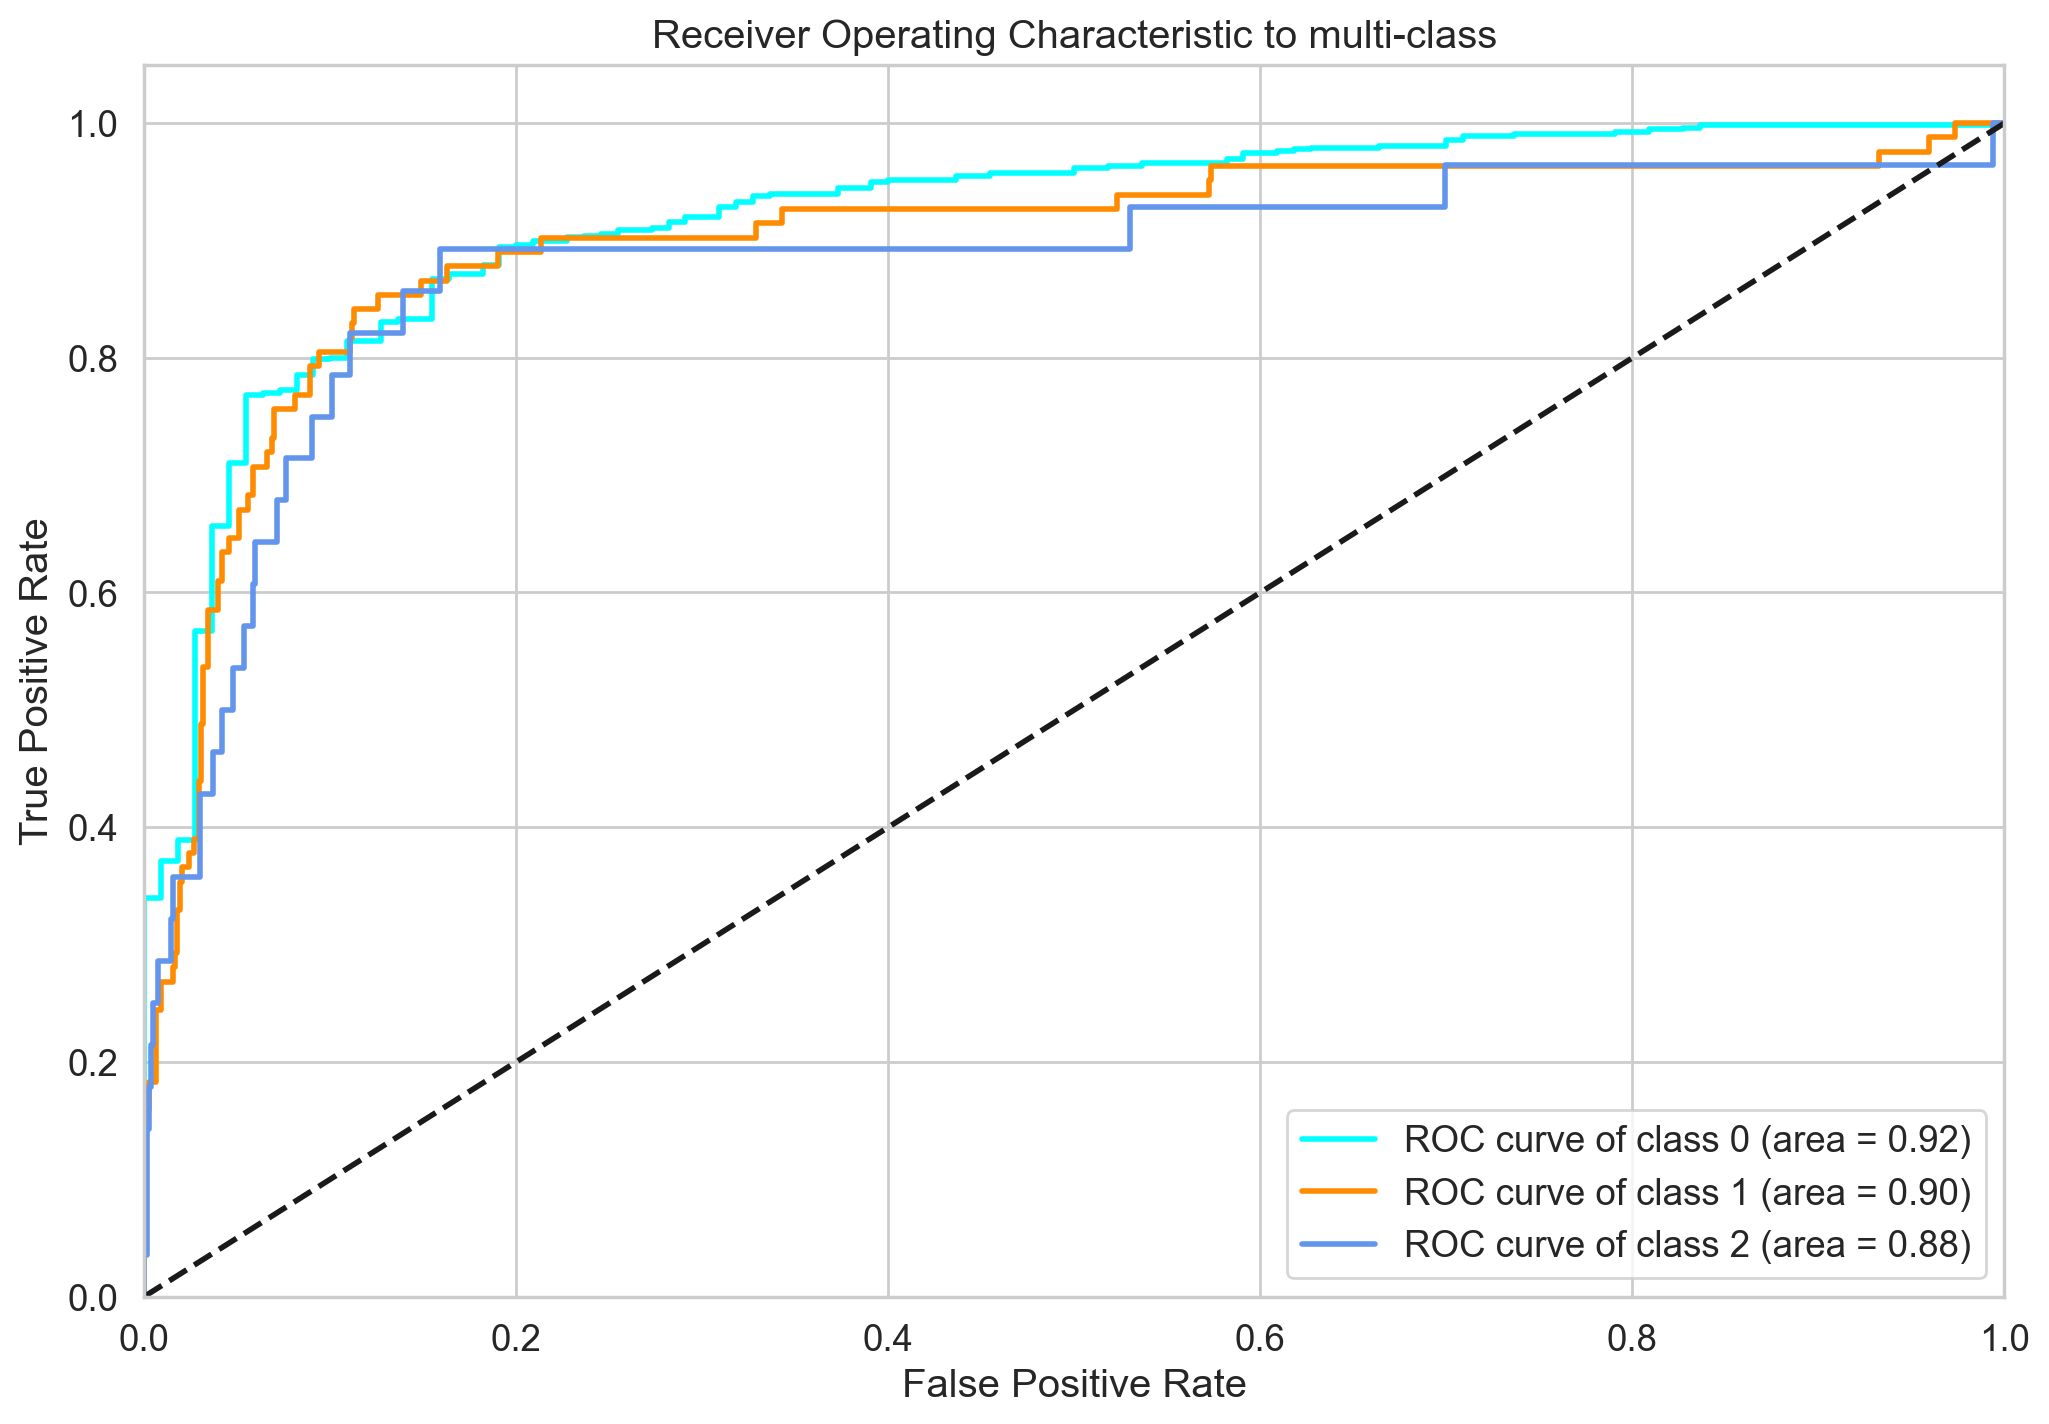

In [21]:
def plot_roc_curve(labels, probs):
    # 计算ROC曲线
    fpr = {}
    tpr = {}
    roc_auc = {}
    
    # 将标签转换为One-hot编码
    test_labels_one_hot = np.eye(3)[labels]
    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(test_labels_one_hot[:, i], probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # 绘制ROC曲线
    plt.figure()
    colors = ['aqua', 'darkorange', 'cornflowerblue']
    for i, color in zip(range(3), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (area = {1:0.2f})'
                                                           ''.format(i, roc_auc[i]))
        
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()

predictions = trainer.predict(test_dataset)
probs = torch.softmax(torch.tensor(predictions.predictions), dim=-1).numpy()
plot_roc_curve(test_labels, probs)

## PR曲线

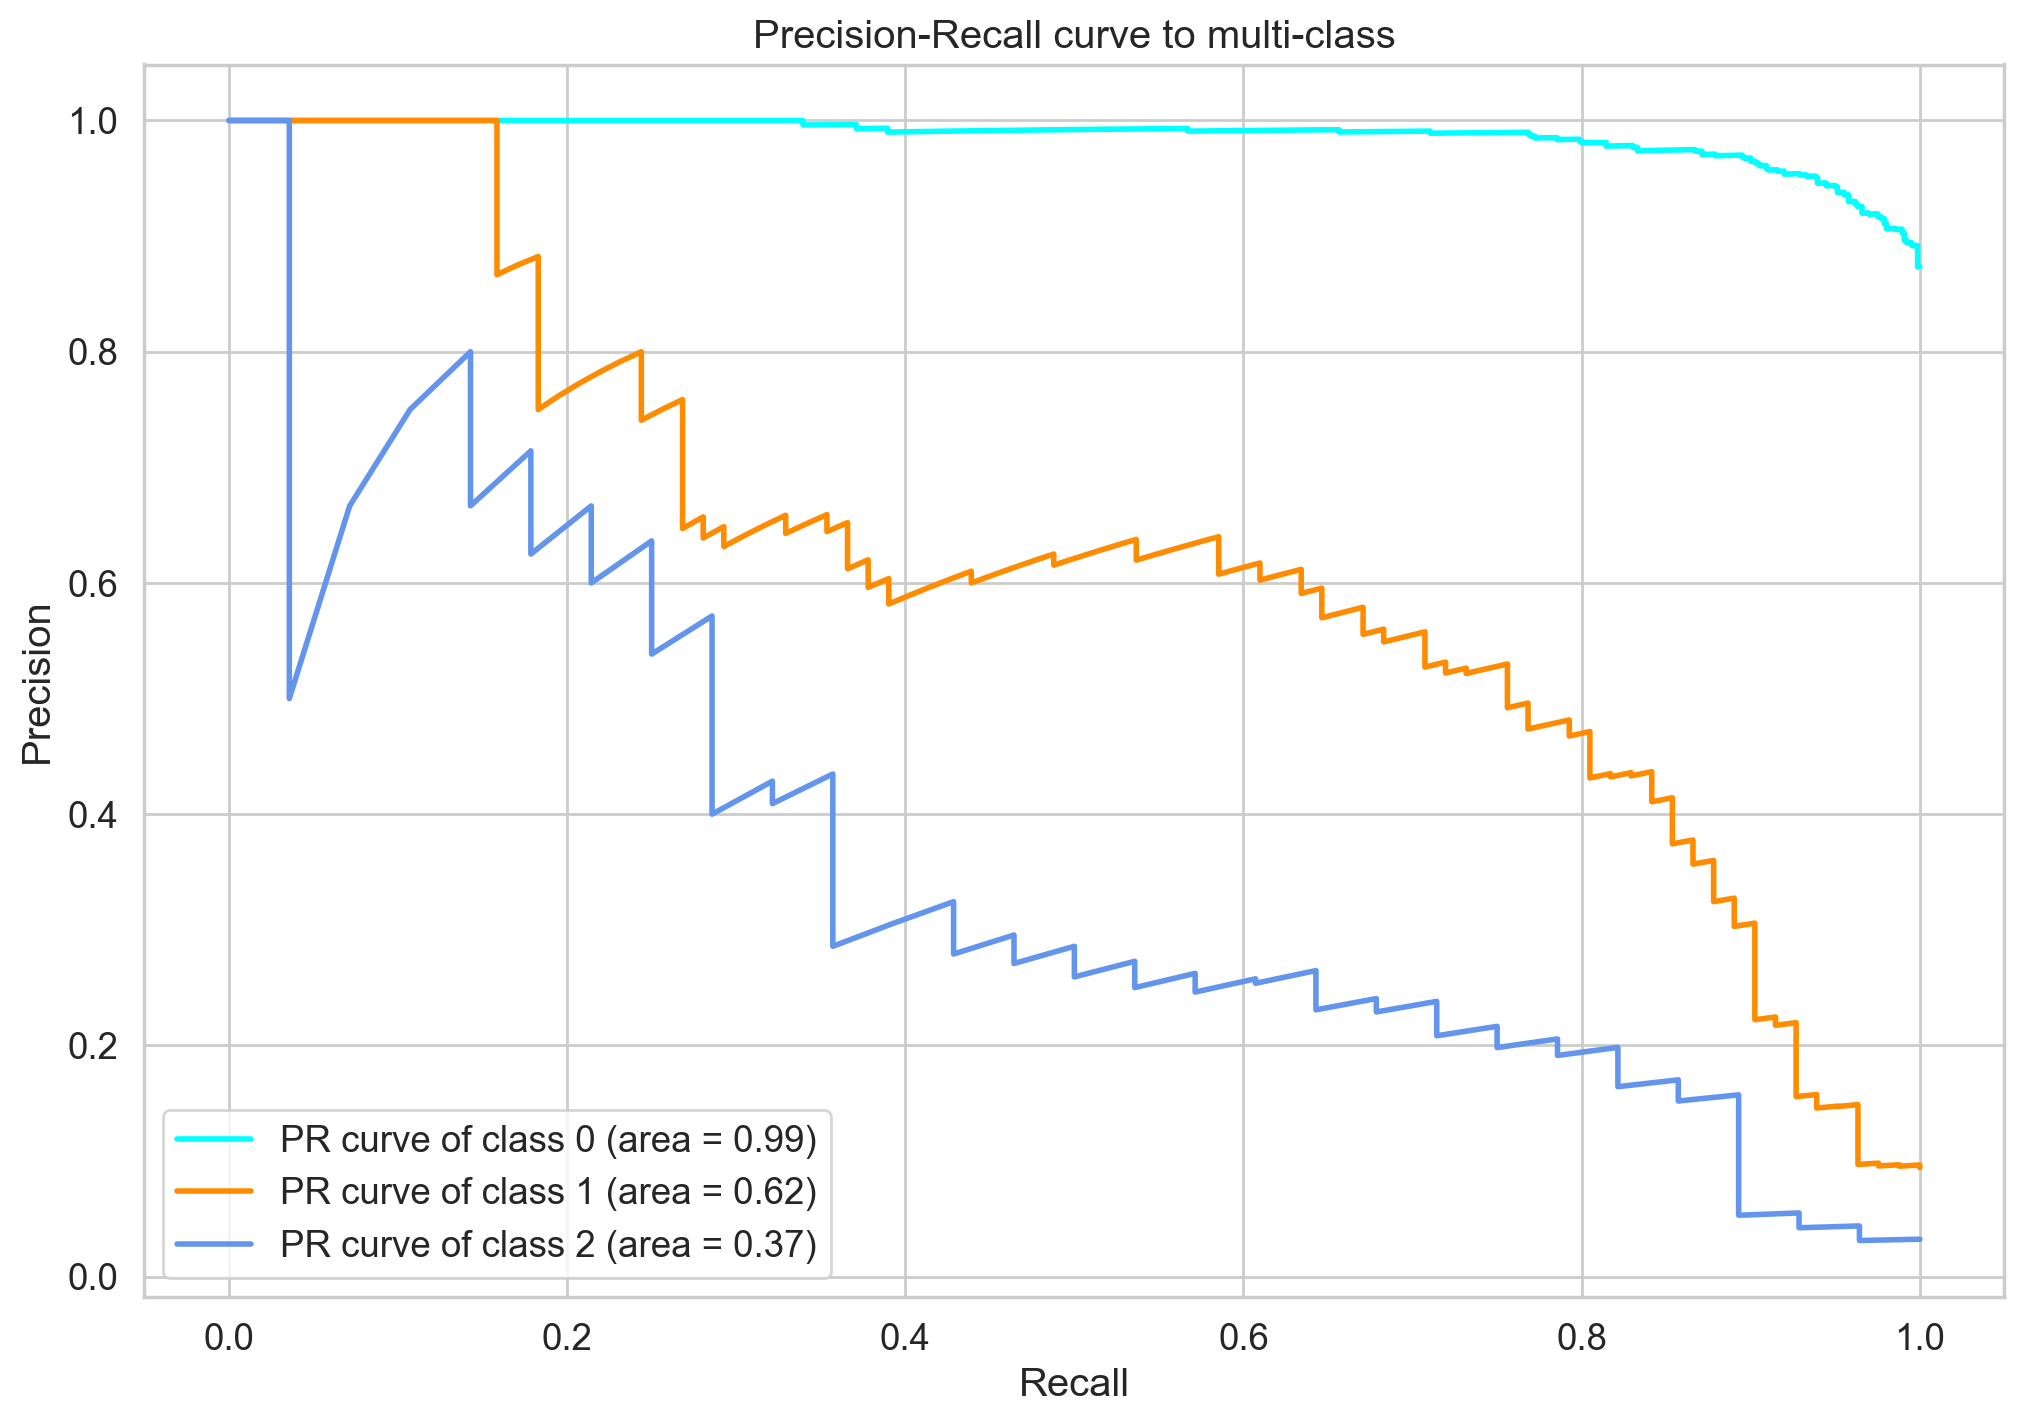

In [22]:
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_pr_curve(labels, probs):
    
    precision = {}
    recall = {}
    average_precision = {}
    test_labels_one_hot = np.eye(3)[labels]
    
    for i in range(3):
        precision[i], recall[i], _ = precision_recall_curve(test_labels_one_hot[:, i], probs[:, i])
        average_precision[i] = average_precision_score(test_labels_one_hot[:, i], probs[:, i])

    plt.figure()
    colors = ['aqua', 'darkorange', 'cornflowerblue']
    for i, color in zip(range(3), colors):
        plt.plot(recall[i], precision[i], color=color, lw=2, label='PR curve of class {0} (area = {1:0.2f})'
                                                           ''.format(i, average_precision[i]))

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve to multi-class')
    plt.legend(loc="best")
    plt.show()

plot_pr_curve(test_labels, probs)

## 混淆矩阵

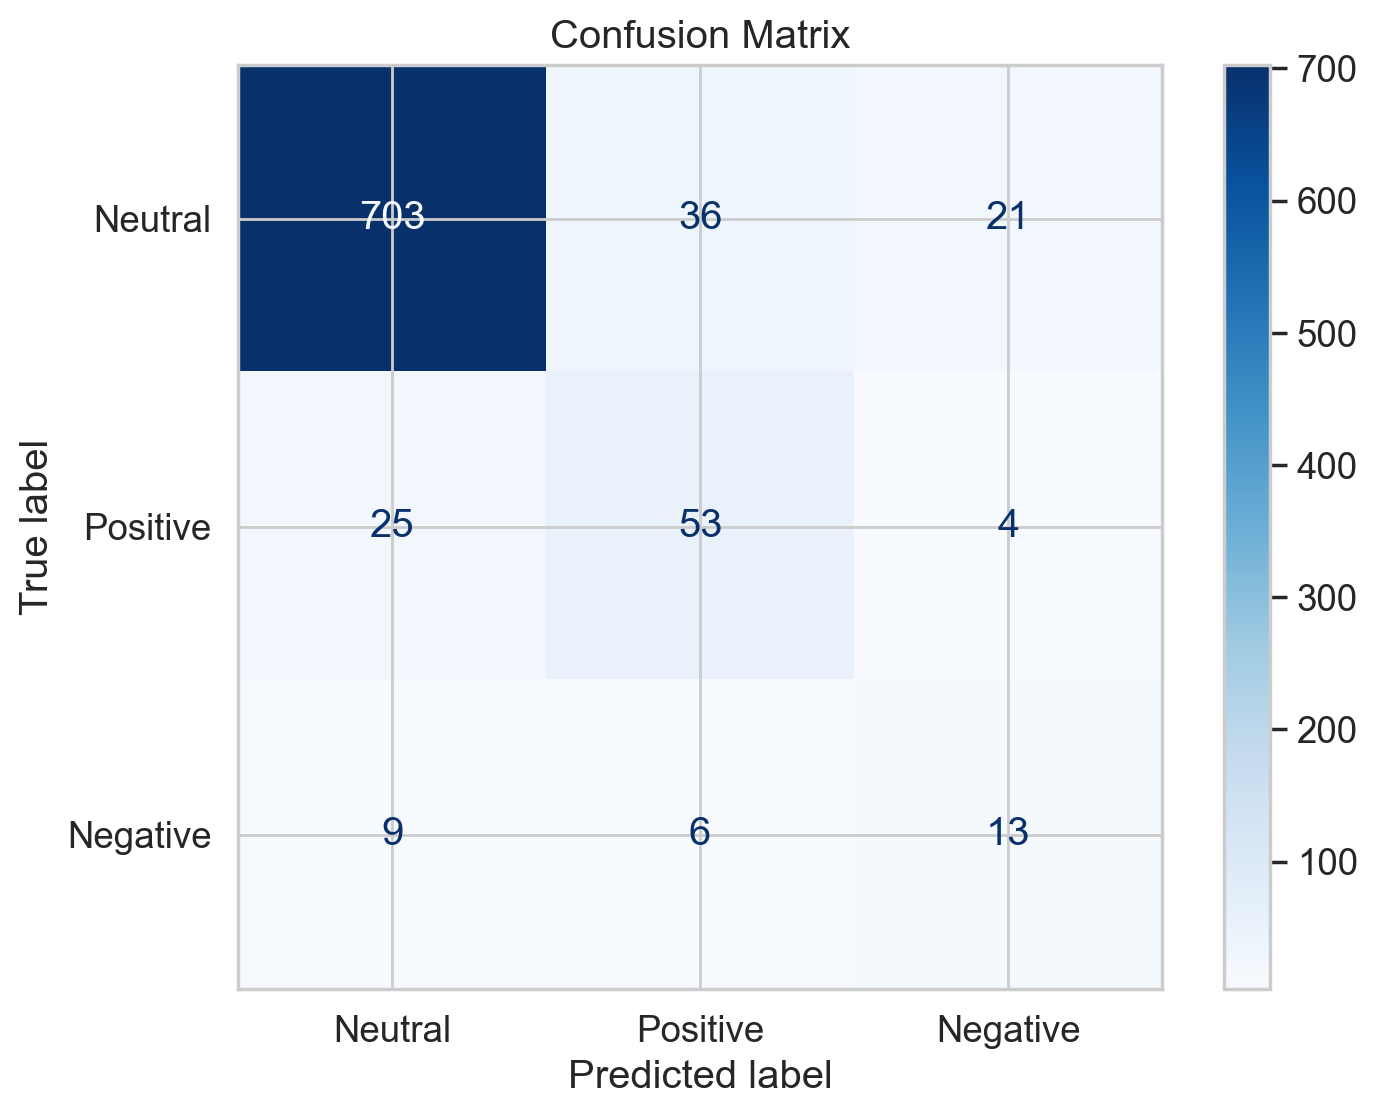

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', values_format='d', ax=ax)
    plt.title('Confusion Matrix')
    plt.show()
    
predicted_labels = np.argmax(predictions.predictions, axis=1)
plot_confusion_matrix(test_labels, predicted_labels, list(label2id.keys()))

## 误差分析

In [24]:
def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        if loss_type == 'dsc_loss':
            loss_fct = MultiDSCLoss(alpha=1.0, smooth=1.0, reduction='none')
        elif loss_type == 'focal_loss':
            loss_fct = MultiFocalLoss(num_class=3, alpha=0.8, gamma=2.0, reduction='none')
        else:
            loss_fct = torch.nn.CrossEntropyLoss(reduction='none')
        loss = loss_fct(output.logits, batch["label"].to(device))

    # Place outputs on CPU for compatibility with other dataset columns   
    return {"loss": loss.cpu().numpy(), 
            "predicted_label": pred_label.cpu().numpy()}

tokenized_data.set_format("torch", columns=["input_ids", "attention_mask", "label"])
tokenized_data["validation"] = tokenized_data["validation"].map(forward_pass_with_label, batched=True, batch_size=16)
tokenized_data.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = tokenized_data["validation"][:][cols]
df_test["label"] = df_test["label"].map(id2label)
df_test["predicted_label"] = (df_test["predicted_label"].map(id2label))
df_test.sort_values("loss", ascending=False).head(10)

Parameter 'function'=<function forward_pass_with_label at 0x000001AB4170AA70> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/870 [00:00<?, ? examples/s]

,text,label,predicted_label,loss
412,Again the best result was obtained with IOB1 (...,Negative,Positive,4.630773
662,"To analyze our methods on IV and OOV words, we...",Negative,Neutral,4.248949
520,2 Motivation and Prior Work While several auth...,Positive,Negative,3.206348
448,"As with similar work (e.g. Brown et al 1992), ...",Negative,Neutral,2.946040
100,This is also the main reason why most summariz...,Positive,Neutral,2.646745
457,"(Brown et al. , 1993) then extended their meth...",Positive,Neutral,2.558296
26,While we have shown an increase in performance...,Negative,Positive,2.522987
537,"1 Introduction During the last few years, SMT ...",Positive,Neutral,2.485331
556,Note that our result on Dataset A is as strong...,Positive,Neutral,2.464350
668,This method has the advantage that it is not l...,Negative,Neutral,2.384118


In [25]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
687,lscript1-regularized log-linear models (lscrip...,Neutral,Neutral,0.000025
44,"Uses Maximum Entropy (Berger et al., 1996) cla...",Neutral,Neutral,0.000026
800,"Running words 1,864 14,437 Vocabulary size 569...",Neutral,Neutral,0.000027
238,"Running words 1,864 14,437 Vocabulary size 569...",Neutral,Neutral,0.000027
319,The K&M model creates a packed parse forest of...,Neutral,Neutral,0.000028
41,We scored systems and our own output using cas...,Neutral,Neutral,0.000028
184,We use the same alignment data for the five la...,Neutral,Neutral,0.000028
536,sister head tag X Table 4: Linguistic features...,Neutral,Neutral,0.000029
689,The supervised methods are based on Maximum En...,Neutral,Neutral,0.000029
358,Co-occurrence statistics is collected from eit...,Neutral,Neutral,0.000029


In [26]:
# from torch.utils.data import DataLoader
# 
# best_model_dir = f'./citation_finetuned_models/{base_model_name}'
# trainer.save_model(best_model_dir)
# best_model = AutoModelForSequenceClassification.from_pretrained(best_model_dir).to(device)

# def load_sentiment_datasets():
#     df = pd.read_csv(f'./data/citation_sentiment_corpus_new.csv')
#     train_texts, test_texts, train_labels, test_labels = train_test_split(df['Citation_Text'].tolist(), df['Sentiment'].tolist(), test_size=0.4, stratify=df['Sentiment'], random_state=seed)
#     return train_texts, train_labels, test_texts, test_labels
# 
# _, _, test_texts, test_labels = load_sentiment_datasets()
# test_dataset = MyDataset(tokenizer(test_texts, truncation=True, padding=True, return_tensors='pt', max_length=512), test_labels)
# predictions = trainer.predict(test_dataset)
# preds = predictions.predictions.argmax(-1)
# 
# # Compute metrics
# accuracy = accuracy_score(test_labels, preds)
# precision, recall, f1, _ = precision_recall_fscore_support(test_labels, preds, average='macro')
# 
# # Print metrics
# print(f"Accuracy: {accuracy:.4f}")
# print(f"Precision: {precision:.4f}")
# print(f"Recall: {recall:.4f}")
# print(f"F1 Score: {f1:.4f}")